In [1]:
%env WANDB_SILENT=True
%env "WANDB_NOTEBOOK_NAME" "del_mc1"

import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torcheval.metrics import MulticlassAccuracy
from sklearn.model_selection import KFold
from config import default_config
import torch.optim as optim
import numpy as np

import wandb

env: WANDB_SILENT=True
env: "WANDB_NOTEBOOK_NAME"="del_mc1"


#### Downloading Datasets
In order to work with the CIFAR10 Dataset, the dataset can be downloaded via the `torchvision` package. An important note at this step is that the CIFAR10 images are not normalized or standardized in any way at the point after downloading it. To later on learn the classes of the dataset it first is normalized on the metrics of the trainset.

In [2]:
unnormalized_transform = transforms.Compose([
    transforms.ToTensor()
])

unnormalized_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=unnormalized_transform)

def calculate_mean_std(dataset):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for images, _ in dataloader:
        for i in range(3):  # Loop through each channel
            mean[i] += images[:,i,:,:].mean()
            std[i] += images[:,i,:,:].std()
    mean.div_(len(dataloader))
    std.div_(len(dataloader))
    return mean, std

mean, std = calculate_mean_std(unnormalized_trainset)
print("Mean: ", mean)
print("Std: ", std)

normalized_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean.numpy(), std.numpy())
])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=normalized_transform)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=normalized_transform)

Files already downloaded and verified
Mean:  tensor([0.4915, 0.4822, 0.4466])
Std:  tensor([0.2463, 0.2428, 0.2607])
Files already downloaded and verified
Files already downloaded and verified


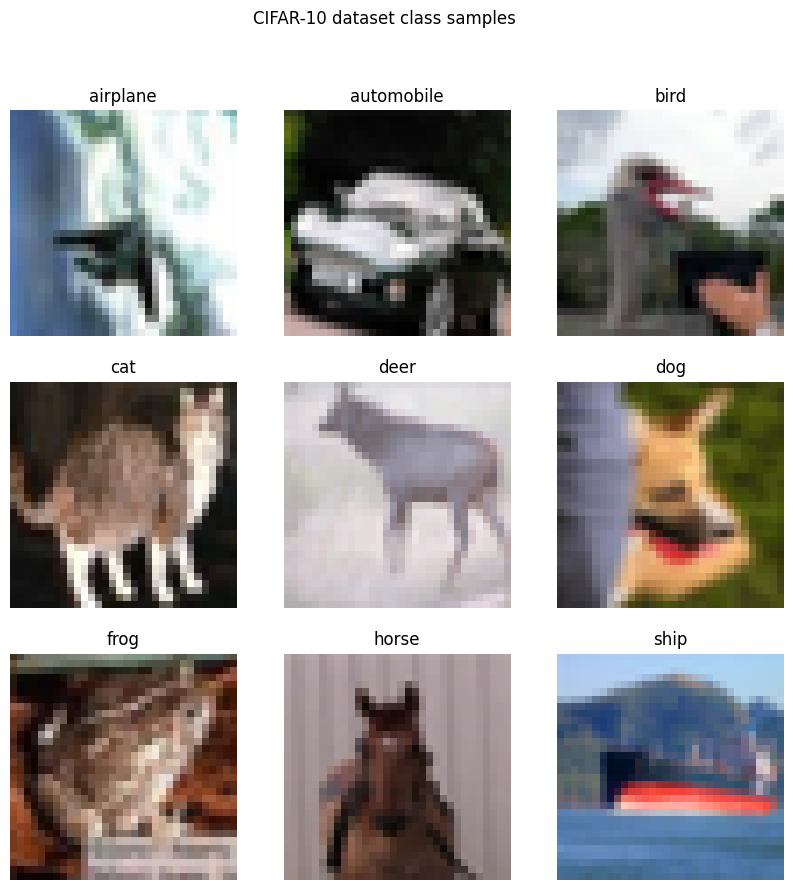

In [3]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('CIFAR-10 dataset class samples')

independent_class_images = dict()

while len(independent_class_images) < 10:
    index = np.random.randint(0, len(cifar_trainset))
    image, label = cifar_trainset[index]
    if label not in independent_class_images:
        independent_class_images[label] = image

def reverse_normalize(tensor_img, mean, std):
    mean = mean.numpy()
    std = std.numpy()

    rev_img = tensor_img.numpy().transpose((1, 2, 0))
    rev_img = rev_img * std + mean
    rev_img = np.clip(rev_img, 0, 1)
    return rev_img

idx = 0
for i in range(3):
    for j in range(3):
        if idx in independent_class_images:
            img_to_plot = reverse_normalize(independent_class_images[idx], mean, std)
            axs[i, j].imshow(img_to_plot)
            axs[i, j].set_title(cifar_trainset.classes[idx])
            axs[i, j].axis('off')
        idx += 1

plt.show()

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Base Functions

In [5]:
def train(model: nn.Module, 
          optimizer, 
          criterion, 
          data_loader: torch.utils.data.DataLoader, 
          device,
          n_classes: int,
          verbose=True, verbose_interval=2000,
          current_epoch: int =1):
    acc = MulticlassAccuracy(num_classes=n_classes, device=device)

    running_loss = 0.0
    verbose_loss = 0.0

    for i, data in enumerate(data_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        acc.update(outputs, labels)
        running_loss += loss.item()
        verbose_loss += loss.item()
        
        if verbose and i % verbose_interval == verbose_interval - 1:
            print(f'[Epoch {current_epoch}, {i + 1}] loss: {verbose_loss / verbose_interval:.3f}')
            verbose_loss = 0.0
    
    train_loss = running_loss / len(data_loader)

    return {"train_accuracy": acc.compute(), "train_loss": train_loss}

In [6]:
def test(model: nn.Module,
         criterion,
         data_loader: torch.utils.data.DataLoader,
         device,
         n_classes: int
         ):
    accuracy = MulticlassAccuracy(num_classes=n_classes, device=device)
    
    model.eval()
    y_true = []
    y_pred = []
    test_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            data, target = data.view(-1, 3, 32, 32), target
            y_true.append(target)

            output = model(data)
            y_pred.append(output)

            test_loss += criterion(output, target).item()

            class_pred = output.argmax(dim=1)

            accuracy.update(class_pred, target)
    
    test_loss /= len(data_loader.dataset)

    return { "test_accuracy": accuracy.compute(), "test_loss": test_loss}

In [20]:
def assess_model(model: nn.Module, 
                 criterion, 
                 optimizer,
                 train_loader: torch.utils.data.DataLoader,
                 test_loader: torch.utils.data.DataLoader,
                 config=default_config,
                 weight_init: str = 'kaiming',
                 learning_rate: float = 0.01,
                 n_epochs: int = 10,
                 n_classes: int = 10,
                 run_name: str = None,
                 tags: list[str] = None,
                 verbose: bool = False
                ):
    torch.manual_seed(config["seed"])
    np.random.seed(config["seed"])

    if optimizer is None:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for m in model.modules():
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            if weight_init == 'kaiming':
                torch.nn.init.kaiming_normal_(m.weight)
            elif weight_init == 'xavier':
                torch.nn.init.xavier_normal_(m.weight)
            elif weight_init == 'normal':
                mean = m.weight.mean().item()
                std = m.weight.std().item()
                torch.nn.init.normal_(m.weight, mean, std)
            else:
                raise ValueError(f"Unknown weight initialization method: {weight_init}")

    with wandb.init(project="del-mc1", 
                    name=run_name if run_name is not None else model.__class__.__name__, 
                    config=default_config,
                    tags=tags if tags is not None else None,
                    settings=wandb.Settings(disable_job_creation=True)
                    ) as run:
        use_cuda = torch.cuda.is_available()

        device = torch.device("cuda" if use_cuda else "cpu")
        model.to(device)
        print(f"--- Running Experiment {run_name} ---")
        torch.manual_seed(config["seed"]) 

        wandb.watch(model, criterion=criterion, log="all", log_graph=True, log_freq=1)
        for epoch in range(1, n_epochs + 1):
            train_metrics = train(model, optimizer, criterion, train_loader, device, n_classes, current_epoch=epoch, verbose=verbose)
            test_metrics = test(model, criterion, test_loader, device, n_classes)
            wandb.log({**train_metrics, **test_metrics, "epoch": epoch})
            print(f"Epoch {epoch} - Train accuracy: {train_metrics['train_accuracy']:.3f}, Test accuracy: {test_metrics['test_accuracy']:.3f}")

        wandb.unwatch(model)
        print(f"View run at: https://wandb.ai/{run.entity}/{run.project}/{run.id}")
        print()


In [13]:
train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=64, shuffle=True, num_workers=4) 
test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=64, shuffle=False, num_workers=4)

## Base Model

In [14]:
def BaseCNN():
    return nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(4096 , 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )

### Customizable Base Model
For the following experiments and analyses, this following function will help to configure new models based on the `BaseCNN`.

In [15]:
def CustomBaseCNN(num_conv_layers=1,
                  filters_per_layer=[16], 
                  kernel_sizes=[3], 
                  strides=[1],
                  paddings=[1], 
                  num_fc_layers=2, 
                  fc_sizes=[512, 10],
                  use_dropout=False,
                  dropout_rate=0.5,
                  use_batchnorm=False,
                  batchnorm_momentum=0.1):
    layers = []

    input_channels = 3
    output_size = 32
    for i in range(num_conv_layers):
        layers.append(nn.Conv2d(input_channels, filters_per_layer[i], kernel_size=kernel_sizes[i], stride=strides[i], padding=paddings[i]))
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(filters_per_layer[i], momentum=batchnorm_momentum))
        layers.append(nn.ReLU())
        if use_dropout:
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.MaxPool2d(2, 2))
        input_channels = filters_per_layer[i]
        output_size = (output_size - kernel_sizes[i] + 2*paddings[i]) // strides[i] + 1
        output_size = output_size // 2

    layers.append(nn.Flatten())

    input_size = input_channels * output_size * output_size

    for i in range(num_fc_layers):
        layers.append(nn.Linear(input_size, fc_sizes[i]))
        if i < num_fc_layers - 1:
            layers.append(nn.ReLU())
            if use_dropout:
                layers.append(nn.Dropout(dropout_rate))
            input_size = fc_sizes[i]

    return nn.Sequential(*layers)

## Overfit Testing
The first exploration done in the Mini Challenge aims to validate the Baseline Model by only propagating and learning a single example. This will show if the model is capable of learning and therefore the expected outcome is that it will show fast convergence and immediate perfect fit (Overfit).

In [21]:
single_sample_subset = torch.utils.data.Subset(cifar_trainset, [0])
single_sample_loader = torch.utils.data.DataLoader(single_sample_subset, batch_size=1, shuffle=False)

assess_model(BaseCNN(), 
             nn.CrossEntropyLoss(),
             None, 
             single_sample_loader, 
             single_sample_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=3,
             n_classes=10,
             run_name="Overfit_Test")

--- Running Experiment Overfit_Test ---
Epoch 1 - Train accuracy: 0.000, Test accuracy: 1.000
Epoch 2 - Train accuracy: 1.000, Test accuracy: 1.000
Epoch 3 - Train accuracy: 1.000, Test accuracy: 1.000
View run at: https://wandb.ai/okaynils/del-mc1/1us5cnnl



In [22]:
%wandb okaynils/del-mc1/reports/Overfitting-Example--Vmlldzo3NTA2NDM5

As expected the model immediately converges after one epoch (or after the single sample has propagated through the network once).

It is therefore safe to assume that this Baseline Model is able to learn and can be used for further experimentation.

## Exploring Weight-Initialization
There are numerous ways to initialize the weights of a network before going through the training process. In this exploration I explicitly looked at the impact that `kaiming_normal_`, `xavier_normal_` and `normal_` have on the baseline model.

### Drawing Weights from Normal Distribution
The `normal_` weight initialization method samples weights from the normal distribution $\mathcal{N}(\text{mean},\text{std}^2)$. The mean and standard deviation used are taken as estimators from the training data's tensor.

### Xavier Weight Initialization
This initialization method takes a similar approach but samples and draws values from a slightly altered normal distribution, namely the **Xavier Normal Distribution**: 
$$\mathcal{N}(0,\text{std}^2)$$
where $$\text{std}=\text{gain}\times\sqrt{\frac{2}{\text{fan\_in}+\text{fan\_out}}}$$

### Kaiming Weight Initialization
The third weight initialization method that was looked at in this mini challenge was the Kaiming Initialization. This method also draws the initialization weights from a slightly modified normal distribution where the standard deviation in $\mathcal{N}(0,\text{std}^2)$ is calculated $$\text{std}=\frac{\text{gain}}{\sqrt{\text{fan\_mode}}}$$

Each of the three experiments at hand was done on the `BaseCNN` Model and the default hyperparameter settings (`learning_rate=0.01`).

In [11]:
assess_model(model=BaseCNN(),
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             n_classes=10,
             weight_init='kaiming',
             run_name="Kaiming_Init")

assess_model(model=BaseCNN(),
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             n_classes=10,
             weight_init='xavier',
             run_name="Xavier_Init")

assess_model(model=BaseCNN(),
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             n_classes=10,
             weight_init='normal',
             run_name="Normal_Init")

--- Running Experiment Kaiming_Init ---
Epoch 1 - Train accuracy: 0.425, Test accuracy: 0.493
Epoch 2 - Train accuracy: 0.534, Test accuracy: 0.528
Epoch 3 - Train accuracy: 0.586, Test accuracy: 0.548
Epoch 4 - Train accuracy: 0.621, Test accuracy: 0.591
Epoch 5 - Train accuracy: 0.653, Test accuracy: 0.602
Epoch 6 - Train accuracy: 0.681, Test accuracy: 0.594
Epoch 7 - Train accuracy: 0.703, Test accuracy: 0.582
Epoch 8 - Train accuracy: 0.727, Test accuracy: 0.623
Epoch 9 - Train accuracy: 0.748, Test accuracy: 0.618
Epoch 10 - Train accuracy: 0.768, Test accuracy: 0.633
Epoch 11 - Train accuracy: 0.791, Test accuracy: 0.560
Epoch 12 - Train accuracy: 0.813, Test accuracy: 0.594
Epoch 13 - Train accuracy: 0.830, Test accuracy: 0.635
Epoch 14 - Train accuracy: 0.849, Test accuracy: 0.621
Epoch 15 - Train accuracy: 0.867, Test accuracy: 0.602
Epoch 16 - Train accuracy: 0.888, Test accuracy: 0.637
Epoch 17 - Train accuracy: 0.904, Test accuracy: 0.643
Epoch 18 - Train accuracy: 0.919, 

In [8]:
%wandb okaynils/del-mc1/reports/Weight-Initialization--Vmlldzo3NTA2NTk5

### Observations
- The three methods follow a stable loss throughout 30 epochs on the training set.
- Between epoch 10-15 the model seems to start to overfit within all explored initialization methods.
- The `Xavier`- and `Normal`-Initialization methods both show some harsh instability in the loss between epoch 25 and 26. The accuracy also dents in at during epoch 25 and 26.

### Interpretation
- The sudden increase of loss and the dent in accuracy at epoch 25/26 could mean that in these epochs the training batch contained some outliers which skewed the model into a less generalized direction.
- Another interpretation or explanation for the sudden loss jump may be that some of the gradients at the observed epochs we're too numerically unstable. The gradient panel in W&B supports that assumption and shows that the gradients took up more variance again at epoch 25 and 26 (weight gradient magnitude between `0.3` and `-0.3`).

### Reflection
The explored methods all yielded similar results. Within the first 15 epochs the model reached a minimum loss for the test set before starting to overfit. It would therfore make sense to work with the model parameters up until epoch 15 and not train further as this would result in an overfit. As for the observed jump in the loss, this issue lied already in the territory of the overfit but if such an event occured before that territory, a measure that I could've looked at would've been **gradient clipping** which tries to prevent exploding gradients and numerical instability by clipping gradients to a maximum threshold value.

## Analyzing Model Depth
Within this experiment the `BaseCNN` will get extended with further **fully connected linear layers**. The models therefore become more complex and it is expected that we should see better results as they can capture a wider range of details with their increase in complexity. This increase also comes with problems such as overfitting as we could approach an **interpolation point** by adding more and more parameters.

### Models
The following three architectures were trained:
- **`depth_3_mlp`**: `BaseCNN` Architecture with `3` Linear Layers in the following unit order: `4096`, `512`, `10`
- **`depth_4_mlp`**: `BaseCNN` Architecture with `4` Linear Layers in the following unit order: `4096`, `512`, `256`, `10`
- **`depth_5_mlp`**: `BaseCNN` Architecture with `5` Linear Layers in the following unit order: `4096`, `512`, `256`, `128`, `10`

In [12]:
depth_3_mlp = CustomBaseCNN(num_fc_layers=3, fc_sizes=[4096, 512, 10])
depth_4_mlp = CustomBaseCNN(num_fc_layers=4, fc_sizes=[4096, 512, 256, 10])
depth_5_mlp = CustomBaseCNN(num_fc_layers=5, fc_sizes=[4096, 512, 256, 128, 10])

assess_model(model=depth_3_mlp,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Depth_3_MLP")

assess_model(model=depth_4_mlp,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Depth_4_MLP")

assess_model(model=depth_5_mlp,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Depth_5_MLP")

--- Running Experiment Depth_3_MLP ---
Epoch 1 - Train accuracy: 0.428, Test accuracy: 0.477
Epoch 2 - Train accuracy: 0.556, Test accuracy: 0.527
Epoch 3 - Train accuracy: 0.614, Test accuracy: 0.547
Epoch 4 - Train accuracy: 0.659, Test accuracy: 0.609
Epoch 5 - Train accuracy: 0.702, Test accuracy: 0.601
Epoch 6 - Train accuracy: 0.743, Test accuracy: 0.553
Epoch 7 - Train accuracy: 0.777, Test accuracy: 0.585
Epoch 8 - Train accuracy: 0.816, Test accuracy: 0.630
Epoch 9 - Train accuracy: 0.852, Test accuracy: 0.608
Epoch 10 - Train accuracy: 0.883, Test accuracy: 0.619
Epoch 11 - Train accuracy: 0.914, Test accuracy: 0.604
Epoch 12 - Train accuracy: 0.943, Test accuracy: 0.588
Epoch 13 - Train accuracy: 0.963, Test accuracy: 0.653
Epoch 14 - Train accuracy: 0.979, Test accuracy: 0.653
Epoch 15 - Train accuracy: 0.991, Test accuracy: 0.596
Epoch 16 - Train accuracy: 0.994, Test accuracy: 0.651
Epoch 17 - Train accuracy: 0.998, Test accuracy: 0.657
Epoch 18 - Train accuracy: 0.998, T

In [23]:
%wandb okaynils/del-mc1/reports/Model-Depth--Vmlldzo3NTA3MjM2

### Observations
- The architectures with `4` and `5` linear layers started to increase in test loss after `3` epochs.
- The architecture with just `3` linear layers showed roughly the same increase but only after `7` epochs.
- After epoch `15` the test loss increased in a very stable manner for all three explored model variants while the train loss converged and moved closer and closer to `0` and its accuracy towards `1`.
- When looking at the Loss and Accuracy on the Training Set, there seem to be small bumps in the otherwise rather smooth graphs.

### Interpretation
- The models showed only a very stead, smooth and slow increase of test loss after the train loss converged to `0`. This may be because the models reached their capacity within the setting of complexity and their hyperparameters. The gradients therefore are very small and barely have an impact. 
- Thus, we can also observe that all the models roughly converge to `66%` accuracy, regardless of complexity.

### Reflection
It would've made sense to also look at the effect other parameters had in this section of analysis. Perhaps also increasing the complexity within the Convolutional Layers would've made sense to explore because the succeeding linear layers can only work with the extracted features of the preceding `conv`-layer and its rather low complexity. I assume the **single** convolutional layer might have been a bottleneck in regard to the possible complexity. 

## Analyzing Number of Filters
This experiment, in contrast to the Depth Analysis, now focuses on the Convolutional Layer(s). To make sure our complexity this time won't be limited by a single `conv`-layer, I defined three models with **two** Convolutional Layers and the **two** linear layers from the `BaseCNN` "default setting".

### Models
The following three architectures were trained:
- **`filter_8_16_cnn`**: `BaseCNN` Architecture with `2` Convolutional Layers with `8` Filters for the first layer and `16` for the second.
- **`filter_16_32_cnn`**: `BaseCNN` Architecture with `2` Convolutional Layers with `16` Filters for the first layer and `32` for the second.
- **`filter_32_64_cnn`**: `BaseCNN` Architecture with `2` Convolutional Layers with `32` Filters for the first layer and `64` for the second.

The other hyperparameters for the Convolutional Layers (kernel size, stride and padding) stay the same since they will be explored independently later on. Between the Convolutional Layers the model uses the ReLU activation function and then pools the outputs with a `MaxPool2d`-Layer in a `(2, 2)` Kernel Size. The order here doesn't really matter since both these functions do commute.

In [13]:
filter_8_16_cnn = CustomBaseCNN(num_conv_layers=2, filters_per_layer=[8, 16], kernel_sizes=[3, 3], strides=[1, 1], paddings=[1, 1])
filter_16_32_cnn = CustomBaseCNN(num_conv_layers=2, filters_per_layer=[16, 32], kernel_sizes=[3, 3], strides=[1, 1], paddings=[1, 1])
filter_32_64_cnn = CustomBaseCNN(num_conv_layers=2, filters_per_layer=[32, 64], kernel_sizes=[3, 3], strides=[1, 1], paddings=[1, 1])

assess_model(model=filter_8_16_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Filter_8_16_CNN")

assess_model(model=filter_16_32_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Filter_16_32_CNN")

assess_model(model=filter_32_64_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Filter_32_64_CNN")

--- Running Experiment Filter_8_16_CNN ---
Epoch 1 - Train accuracy: 0.397, Test accuracy: 0.415
Epoch 2 - Train accuracy: 0.501, Test accuracy: 0.491
Epoch 3 - Train accuracy: 0.546, Test accuracy: 0.528
Epoch 4 - Train accuracy: 0.576, Test accuracy: 0.553
Epoch 5 - Train accuracy: 0.600, Test accuracy: 0.565
Epoch 6 - Train accuracy: 0.624, Test accuracy: 0.562
Epoch 7 - Train accuracy: 0.639, Test accuracy: 0.564
Epoch 8 - Train accuracy: 0.658, Test accuracy: 0.610
Epoch 9 - Train accuracy: 0.671, Test accuracy: 0.587
Epoch 10 - Train accuracy: 0.683, Test accuracy: 0.614
Epoch 11 - Train accuracy: 0.698, Test accuracy: 0.558
Epoch 12 - Train accuracy: 0.712, Test accuracy: 0.621
Epoch 13 - Train accuracy: 0.723, Test accuracy: 0.631
Epoch 14 - Train accuracy: 0.734, Test accuracy: 0.598
Epoch 15 - Train accuracy: 0.745, Test accuracy: 0.594
Epoch 16 - Train accuracy: 0.759, Test accuracy: 0.596
Epoch 17 - Train accuracy: 0.769, Test accuracy: 0.652
Epoch 18 - Train accuracy: 0.78

In [10]:
%wandb okaynils/del-mc1/reports/Number-of-Filters--Vmlldzo3NTE3Njc3

### Observations
- The most complex model with two convolutional layers with `32` filters in the first and `64` in the second layer was able to converge in about `20` epochs, so it was the fastest convergence among the explored number of filters. It also reached `70%` accuracy on the testset, which is the highest accuracy up until this point.
- Some instability can be observed beginning at around epoch `25` among the two less complex models `Filter_16_32_CNN` and `Filter_8_16_CNN`.
- The test_loss decreases in a stable manner up until epoch `9` and then increases. 

### Interpretation
- The model with up to `64` filters on a convolutional layer should be able to extract more detailed features. Therefore it is expected that this variant works out the best results.
- As for the instability at the later epochs of the test loss it can be expected that again some samples in the batch were likely to be noisy outliers that aren't captured by the test set.

### Reflection
As can be seen the more complex model(s) reached higher accuracies. Perhaps it would have also be worthwhile to look at an even higher number of filters per layer to really see where a maximum of complexity is reached and the images essentially get too small for a more complex model to be sensible.

## Analyzing Kernel Size
In this section the Kernel Size of the filters will be explored. For this analysis again three models, distinctive in their kernel size, were trained.

### Models
The following three architectures were trained:
- **`kernel_3_cnn`**: `BaseCNN` Architecture with a `3x3` Kernel Size and `padding=1` in the Convolutional Layer
- **`kernel_5_cnn`**: `BaseCNN` Architecture with a `5x5` Kernel Size and `padding=2` in the Convolutional Layer
- **`kernel_7_cnn`**: `BaseCNN` Architecture with a `7x7` Kernel Size and `padding=3` in the Convolutional Layer

The other hyperparameters stay the same (default `BaseCNN` settings), so the number of filters in the `conv2d`-layer is `16` and `stride=1`.

In [11]:
kernel_3_cnn = CustomBaseCNN(num_conv_layers=1, filters_per_layer=[16], kernel_sizes=[3], strides=[1], paddings=[1])
kernel_5_cnn = CustomBaseCNN(num_conv_layers=1, filters_per_layer=[16], kernel_sizes=[5], strides=[1], paddings=[2])
kernel_7_cnn = CustomBaseCNN(num_conv_layers=1, filters_per_layer=[16], kernel_sizes=[7], strides=[1], paddings=[3])

assess_model(model=kernel_3_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Kernel_3_CNN")

assess_model(model=kernel_5_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Kernel_5_CNN")

assess_model(model=kernel_7_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Kernel_7_CNN")


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

--- Running Experiment Kernel_3_CNN ---
Epoch 1 - Train accuracy: 0.424, Test accuracy: 0.487
Epoch 2 - Train accuracy: 0.538, Test accuracy: 0.535
Epoch 3 - Train accuracy: 0.589, Test accuracy: 0.551
Epoch 4 - Train accuracy: 0.625, Test accuracy: 0.593
Epoch 5 - Train accuracy: 0.655, Test accuracy: 0.603
Epoch 6 - Train accuracy: 0.684, Test accuracy: 0.577
Epoch 7 - Train accuracy: 0.706, Test accuracy: 0.590
Epoch 8 - Train accuracy: 0.729, Test accuracy: 0.619
Epoch 9 - Train accuracy: 0.750, Test accuracy: 0.612
Epoch 10 - Train accuracy: 0.771, Test accuracy: 0.630
Epoch 11 - Train accuracy: 0.792, Test accuracy: 0.571
Epoch 12 - Train accuracy: 0.813, Test accuracy: 0.601
Epoch 13 - Train accuracy: 0.830, Test accuracy: 0.636
Epoch 14 - Train accuracy: 0.851, Test accuracy: 0.636
Epoch 15 - Train accuracy: 0.870, Test accuracy: 0.599
Epoch 16 - Train accuracy: 0.889, Test accuracy: 0.631
Epoch 17 - Train accuracy: 0.905, Test accuracy: 0.640
Epoch 18 - Train accuracy: 0.920, 

--- Running Experiment Kernel_5_CNN ---
Epoch 1 - Train accuracy: 0.435, Test accuracy: 0.495
Epoch 2 - Train accuracy: 0.549, Test accuracy: 0.524
Epoch 3 - Train accuracy: 0.604, Test accuracy: 0.560
Epoch 4 - Train accuracy: 0.643, Test accuracy: 0.605
Epoch 5 - Train accuracy: 0.678, Test accuracy: 0.612
Epoch 6 - Train accuracy: 0.706, Test accuracy: 0.569
Epoch 7 - Train accuracy: 0.729, Test accuracy: 0.587
Epoch 8 - Train accuracy: 0.754, Test accuracy: 0.632
Epoch 9 - Train accuracy: 0.778, Test accuracy: 0.613
Epoch 10 - Train accuracy: 0.801, Test accuracy: 0.651
Epoch 11 - Train accuracy: 0.823, Test accuracy: 0.544
Epoch 12 - Train accuracy: 0.846, Test accuracy: 0.591
Epoch 13 - Train accuracy: 0.865, Test accuracy: 0.643
Epoch 14 - Train accuracy: 0.887, Test accuracy: 0.650
Epoch 15 - Train accuracy: 0.905, Test accuracy: 0.625
Epoch 16 - Train accuracy: 0.925, Test accuracy: 0.641
Epoch 17 - Train accuracy: 0.941, Test accuracy: 0.655
Epoch 18 - Train accuracy: 0.957, 

--- Running Experiment Kernel_7_CNN ---
Epoch 1 - Train accuracy: 0.436, Test accuracy: 0.460
Epoch 2 - Train accuracy: 0.547, Test accuracy: 0.532
Epoch 3 - Train accuracy: 0.603, Test accuracy: 0.568
Epoch 4 - Train accuracy: 0.641, Test accuracy: 0.592
Epoch 5 - Train accuracy: 0.675, Test accuracy: 0.607
Epoch 6 - Train accuracy: 0.704, Test accuracy: 0.588
Epoch 7 - Train accuracy: 0.730, Test accuracy: 0.613
Epoch 8 - Train accuracy: 0.757, Test accuracy: 0.631
Epoch 9 - Train accuracy: 0.779, Test accuracy: 0.631
Epoch 10 - Train accuracy: 0.805, Test accuracy: 0.646
Epoch 11 - Train accuracy: 0.829, Test accuracy: 0.543
Epoch 12 - Train accuracy: 0.850, Test accuracy: 0.613
Epoch 13 - Train accuracy: 0.874, Test accuracy: 0.637
Epoch 14 - Train accuracy: 0.892, Test accuracy: 0.613
Epoch 15 - Train accuracy: 0.912, Test accuracy: 0.646
Epoch 16 - Train accuracy: 0.931, Test accuracy: 0.642
Epoch 17 - Train accuracy: 0.947, Test accuracy: 0.650
Epoch 18 - Train accuracy: 0.961, 

In [11]:
%wandb okaynils/del-mc1/reports/Kernel-Size--Vmlldzo3NTE3NzIy

### Observations
- The train loss is decreases steadily for all three explored Kernel Sizes. The model variant with a kernel size of `7x7` reaches convergence the earliest.
- The test loss also decreases steadily up until epoch `9` and then increases including some numerical instability which happens at the same time for most of the models.

### Interpretation
- It seems as the models profit from larger kernel sizes because they are more *sample efficient*, similar to the increase in convolutional layers in the section before.
- The larger kernels also capture less fine-grained details. This results in the filters producing a more generalized view of the features, so larger kernels could be looked at as a sort of regularization.

### Reflection
During this experiment I was only able to look at a small range of kernel configurations. I suspect that there also is a lot of synergy with other hyperparameters such as the learning rate that might make sense to explore in combination with the kernel size to actually see how each size adapts the best.

## Analyzing Stride
To analyze the effects the stride has, I again look at the `BaseCNN` configuration but just change the `stride` hyperparameter. An issue at hand is that the `CIFAR-10` image set just consists of `32x32` pixel images, so choosing a too high stride could potentially lead to the filter not being very useful if it only applies to a small fraction of the image's regions.

### Models
The following three architectures were trained:
- **`kernel_3_cnn`**: `BaseCNN` Architecture with a `3x3` Kernel Size and `padding=1` in the Convolutional Layer
- **`kernel_5_cnn`**: `BaseCNN` Architecture with a `5x5` Kernel Size and `padding=2` in the Convolutional Layer
- **`kernel_7_cnn`**: `BaseCNN` Architecture with a `7x7` Kernel Size and `padding=3` in the Convolutional Layer

The other hyperparameters stay the same (default `BaseCNN` settings), so the number of filters in the `conv2d`-layer is `16` and `stride=1`.

In [13]:
stride_1_cnn = CustomBaseCNN(strides=[1])
stride_2_cnn = CustomBaseCNN(strides=[2])
stride_3_cnn = CustomBaseCNN(strides=[3])

assess_model(model=stride_1_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Stride_1_CNN")

assess_model(model=stride_2_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Stride_2_CNN")

assess_model(model=stride_3_cnn,
             criterion=nn.CrossEntropyLoss(),
             optimizer=None,
             train_loader=train_loader,
             test_loader=test_loader,
             config=default_config,
             learning_rate=0.01,
             n_epochs=30,
             run_name="Stride_3_CNN")

--- Running Experiment Stride_1_CNN ---
Epoch 1 - Train accuracy: 0.427, Test accuracy: 0.492
Epoch 2 - Train accuracy: 0.542, Test accuracy: 0.528
Epoch 3 - Train accuracy: 0.592, Test accuracy: 0.558
Epoch 4 - Train accuracy: 0.626, Test accuracy: 0.596
Epoch 5 - Train accuracy: 0.658, Test accuracy: 0.605
Epoch 6 - Train accuracy: 0.685, Test accuracy: 0.582
Epoch 7 - Train accuracy: 0.705, Test accuracy: 0.595
Epoch 8 - Train accuracy: 0.730, Test accuracy: 0.624
Epoch 9 - Train accuracy: 0.751, Test accuracy: 0.616
Epoch 10 - Train accuracy: 0.772, Test accuracy: 0.631
Epoch 11 - Train accuracy: 0.793, Test accuracy: 0.556
Epoch 12 - Train accuracy: 0.811, Test accuracy: 0.587
Epoch 13 - Train accuracy: 0.832, Test accuracy: 0.633
Epoch 14 - Train accuracy: 0.852, Test accuracy: 0.635
Epoch 15 - Train accuracy: 0.869, Test accuracy: 0.568
Epoch 16 - Train accuracy: 0.889, Test accuracy: 0.633
Epoch 17 - Train accuracy: 0.905, Test accuracy: 0.640
Epoch 18 - Train accuracy: 0.921, 

--- Running Experiment Stride_2_CNN ---
Epoch 1 - Train accuracy: 0.402, Test accuracy: 0.469
Epoch 2 - Train accuracy: 0.509, Test accuracy: 0.501
Epoch 3 - Train accuracy: 0.547, Test accuracy: 0.538
Epoch 4 - Train accuracy: 0.573, Test accuracy: 0.566
Epoch 5 - Train accuracy: 0.595, Test accuracy: 0.572
Epoch 6 - Train accuracy: 0.612, Test accuracy: 0.580
Epoch 7 - Train accuracy: 0.626, Test accuracy: 0.570
Epoch 8 - Train accuracy: 0.642, Test accuracy: 0.592
Epoch 9 - Train accuracy: 0.655, Test accuracy: 0.606
Epoch 10 - Train accuracy: 0.666, Test accuracy: 0.607
Epoch 11 - Train accuracy: 0.680, Test accuracy: 0.558
Epoch 12 - Train accuracy: 0.693, Test accuracy: 0.593
Epoch 13 - Train accuracy: 0.702, Test accuracy: 0.617
Epoch 14 - Train accuracy: 0.713, Test accuracy: 0.601
Epoch 15 - Train accuracy: 0.724, Test accuracy: 0.606
Epoch 16 - Train accuracy: 0.732, Test accuracy: 0.608
Epoch 17 - Train accuracy: 0.743, Test accuracy: 0.631
Epoch 18 - Train accuracy: 0.753, 

--- Running Experiment Stride_3_CNN ---
Epoch 1 - Train accuracy: 0.362, Test accuracy: 0.432
Epoch 2 - Train accuracy: 0.459, Test accuracy: 0.453
Epoch 3 - Train accuracy: 0.493, Test accuracy: 0.498
Epoch 4 - Train accuracy: 0.517, Test accuracy: 0.512
Epoch 5 - Train accuracy: 0.534, Test accuracy: 0.510
Epoch 6 - Train accuracy: 0.548, Test accuracy: 0.520
Epoch 7 - Train accuracy: 0.559, Test accuracy: 0.525
Epoch 8 - Train accuracy: 0.570, Test accuracy: 0.546
Epoch 9 - Train accuracy: 0.578, Test accuracy: 0.527
Epoch 10 - Train accuracy: 0.587, Test accuracy: 0.557
Epoch 11 - Train accuracy: 0.596, Test accuracy: 0.529
Epoch 12 - Train accuracy: 0.604, Test accuracy: 0.552
Epoch 13 - Train accuracy: 0.609, Test accuracy: 0.574
Epoch 14 - Train accuracy: 0.618, Test accuracy: 0.561
Epoch 15 - Train accuracy: 0.625, Test accuracy: 0.564
Epoch 16 - Train accuracy: 0.630, Test accuracy: 0.576
Epoch 17 - Train accuracy: 0.638, Test accuracy: 0.583
Epoch 18 - Train accuracy: 0.641, 

In [12]:
%wandb okaynils/del-mc1/reports/Stride--Vmlldzo3NTE3NzY0

### Observations

### Interpretation

### Reflection

## Analyzing Padding

In [14]:
padding_1_cnn = CustomBaseCNN(paddings=[1])
padding_3_cnn = CustomBaseCNN(paddings=[3])
padding_6_cnn = CustomBaseCNN(paddings=[6])

assess_model(model=padding_1_cnn,
                criterion=nn.CrossEntropyLoss(),
                optimizer=None,
                train_loader=train_loader,
                test_loader=test_loader,
                config=default_config,
                learning_rate=0.01,
                n_epochs=30,
                run_name="Padding_1_CNN")

assess_model(model=padding_3_cnn,
                criterion=nn.CrossEntropyLoss(),
                optimizer=None,
                train_loader=train_loader,
                test_loader=test_loader,
                config=default_config,
                learning_rate=0.01,
                n_epochs=30,
                run_name="Padding_2_CNN")

assess_model(model=padding_6_cnn,
                criterion=nn.CrossEntropyLoss(),
                optimizer=None,
                train_loader=train_loader,
                test_loader=test_loader,
                config=default_config,
                learning_rate=0.01,
                n_epochs=30,
                run_name="Padding_3_CNN")

--- Running Experiment Padding_1_CNN ---
Epoch 1 - Train accuracy: 0.427, Test accuracy: 0.490
Epoch 2 - Train accuracy: 0.539, Test accuracy: 0.530
Epoch 3 - Train accuracy: 0.592, Test accuracy: 0.558
Epoch 4 - Train accuracy: 0.625, Test accuracy: 0.596
Epoch 5 - Train accuracy: 0.657, Test accuracy: 0.602
Epoch 6 - Train accuracy: 0.684, Test accuracy: 0.580
Epoch 7 - Train accuracy: 0.706, Test accuracy: 0.594
Epoch 8 - Train accuracy: 0.730, Test accuracy: 0.625
Epoch 9 - Train accuracy: 0.751, Test accuracy: 0.619
Epoch 10 - Train accuracy: 0.771, Test accuracy: 0.636
Epoch 11 - Train accuracy: 0.793, Test accuracy: 0.553
Epoch 12 - Train accuracy: 0.811, Test accuracy: 0.579
Epoch 13 - Train accuracy: 0.833, Test accuracy: 0.633
Epoch 14 - Train accuracy: 0.851, Test accuracy: 0.627
Epoch 15 - Train accuracy: 0.870, Test accuracy: 0.590
Epoch 16 - Train accuracy: 0.890, Test accuracy: 0.636
Epoch 17 - Train accuracy: 0.906, Test accuracy: 0.638
Epoch 18 - Train accuracy: 0.920,

--- Running Experiment Padding_2_CNN ---
Epoch 1 - Train accuracy: 0.431, Test accuracy: 0.494
Epoch 2 - Train accuracy: 0.539, Test accuracy: 0.518
Epoch 3 - Train accuracy: 0.589, Test accuracy: 0.554
Epoch 4 - Train accuracy: 0.624, Test accuracy: 0.594
Epoch 5 - Train accuracy: 0.653, Test accuracy: 0.600
Epoch 6 - Train accuracy: 0.682, Test accuracy: 0.598
Epoch 7 - Train accuracy: 0.702, Test accuracy: 0.577
Epoch 8 - Train accuracy: 0.727, Test accuracy: 0.618
Epoch 9 - Train accuracy: 0.746, Test accuracy: 0.583
Epoch 10 - Train accuracy: 0.766, Test accuracy: 0.628
Epoch 11 - Train accuracy: 0.788, Test accuracy: 0.559
Epoch 12 - Train accuracy: 0.809, Test accuracy: 0.608
Epoch 13 - Train accuracy: 0.827, Test accuracy: 0.644
Epoch 14 - Train accuracy: 0.847, Test accuracy: 0.622
Epoch 15 - Train accuracy: 0.864, Test accuracy: 0.586
Epoch 16 - Train accuracy: 0.884, Test accuracy: 0.621
Epoch 17 - Train accuracy: 0.900, Test accuracy: 0.646
Epoch 18 - Train accuracy: 0.912,

--- Running Experiment Padding_3_CNN ---
Epoch 1 - Train accuracy: 0.436, Test accuracy: 0.499
Epoch 2 - Train accuracy: 0.546, Test accuracy: 0.526
Epoch 3 - Train accuracy: 0.597, Test accuracy: 0.557
Epoch 4 - Train accuracy: 0.632, Test accuracy: 0.595
Epoch 5 - Train accuracy: 0.663, Test accuracy: 0.605
Epoch 6 - Train accuracy: 0.692, Test accuracy: 0.578
Epoch 7 - Train accuracy: 0.714, Test accuracy: 0.590
Epoch 8 - Train accuracy: 0.737, Test accuracy: 0.625
Epoch 9 - Train accuracy: 0.760, Test accuracy: 0.562
Epoch 10 - Train accuracy: 0.782, Test accuracy: 0.619
Epoch 11 - Train accuracy: 0.804, Test accuracy: 0.525
Epoch 12 - Train accuracy: 0.823, Test accuracy: 0.599
Epoch 13 - Train accuracy: 0.845, Test accuracy: 0.638
Epoch 14 - Train accuracy: 0.862, Test accuracy: 0.639
Epoch 15 - Train accuracy: 0.882, Test accuracy: 0.583
Epoch 16 - Train accuracy: 0.898, Test accuracy: 0.639
Epoch 17 - Train accuracy: 0.916, Test accuracy: 0.630
Epoch 18 - Train accuracy: 0.929,

In [13]:
%wandb okaynils/del-mc1/reports/Padding--Vmlldzo3NTE3OTAz

### Observations

### Interpretation

### Reflection

## Analyzing Batch Size

In [15]:
for batch_size in [64, 128, 256]:
    assess_model(model=BaseCNN(),
                 criterion=nn.CrossEntropyLoss(),
                 optimizer=None,
                 train_loader=torch.utils.data.DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True),
                 test_loader=torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size, shuffle=False),
                 config=default_config,
                 learning_rate=0.01,
                 n_epochs=30,
                 run_name=f"Batch_Size_{batch_size}")

--- Running Experiment Batch_Size_64 ---
Epoch 1 - Train accuracy: 0.426, Test accuracy: 0.493
Epoch 2 - Train accuracy: 0.541, Test accuracy: 0.528
Epoch 3 - Train accuracy: 0.591, Test accuracy: 0.560
Epoch 4 - Train accuracy: 0.625, Test accuracy: 0.599
Epoch 5 - Train accuracy: 0.656, Test accuracy: 0.607
Epoch 6 - Train accuracy: 0.684, Test accuracy: 0.583
Epoch 7 - Train accuracy: 0.706, Test accuracy: 0.594
Epoch 8 - Train accuracy: 0.731, Test accuracy: 0.624
Epoch 9 - Train accuracy: 0.750, Test accuracy: 0.621
Epoch 10 - Train accuracy: 0.771, Test accuracy: 0.631
Epoch 11 - Train accuracy: 0.794, Test accuracy: 0.558
Epoch 12 - Train accuracy: 0.812, Test accuracy: 0.581
Epoch 13 - Train accuracy: 0.832, Test accuracy: 0.633
Epoch 14 - Train accuracy: 0.851, Test accuracy: 0.631
Epoch 15 - Train accuracy: 0.870, Test accuracy: 0.611
Epoch 16 - Train accuracy: 0.889, Test accuracy: 0.635
Epoch 17 - Train accuracy: 0.905, Test accuracy: 0.637
Epoch 18 - Train accuracy: 0.921,

--- Running Experiment Batch_Size_128 ---
Epoch 1 - Train accuracy: 0.395, Test accuracy: 0.469
Epoch 2 - Train accuracy: 0.500, Test accuracy: 0.516
Epoch 3 - Train accuracy: 0.546, Test accuracy: 0.539
Epoch 4 - Train accuracy: 0.579, Test accuracy: 0.555
Epoch 5 - Train accuracy: 0.605, Test accuracy: 0.578
Epoch 6 - Train accuracy: 0.627, Test accuracy: 0.560
Epoch 7 - Train accuracy: 0.645, Test accuracy: 0.586
Epoch 8 - Train accuracy: 0.664, Test accuracy: 0.597
Epoch 9 - Train accuracy: 0.676, Test accuracy: 0.611
Epoch 10 - Train accuracy: 0.691, Test accuracy: 0.618
Epoch 11 - Train accuracy: 0.706, Test accuracy: 0.617
Epoch 12 - Train accuracy: 0.722, Test accuracy: 0.601
Epoch 13 - Train accuracy: 0.734, Test accuracy: 0.637
Epoch 14 - Train accuracy: 0.748, Test accuracy: 0.626
Epoch 15 - Train accuracy: 0.761, Test accuracy: 0.626
Epoch 16 - Train accuracy: 0.771, Test accuracy: 0.622
Epoch 17 - Train accuracy: 0.785, Test accuracy: 0.632
Epoch 18 - Train accuracy: 0.795

--- Running Experiment Batch_Size_256 ---
Epoch 1 - Train accuracy: 0.359, Test accuracy: 0.426
Epoch 2 - Train accuracy: 0.461, Test accuracy: 0.464
Epoch 3 - Train accuracy: 0.501, Test accuracy: 0.485
Epoch 4 - Train accuracy: 0.532, Test accuracy: 0.509
Epoch 5 - Train accuracy: 0.553, Test accuracy: 0.528
Epoch 6 - Train accuracy: 0.571, Test accuracy: 0.499
Epoch 7 - Train accuracy: 0.588, Test accuracy: 0.534
Epoch 8 - Train accuracy: 0.600, Test accuracy: 0.548
Epoch 9 - Train accuracy: 0.617, Test accuracy: 0.571
Epoch 10 - Train accuracy: 0.627, Test accuracy: 0.576
Epoch 11 - Train accuracy: 0.638, Test accuracy: 0.563
Epoch 12 - Train accuracy: 0.651, Test accuracy: 0.543
Epoch 13 - Train accuracy: 0.658, Test accuracy: 0.588
Epoch 14 - Train accuracy: 0.669, Test accuracy: 0.599
Epoch 15 - Train accuracy: 0.680, Test accuracy: 0.576
Epoch 16 - Train accuracy: 0.684, Test accuracy: 0.581
Epoch 17 - Train accuracy: 0.696, Test accuracy: 0.597
Epoch 18 - Train accuracy: 0.702

In [14]:
%wandb okaynils/del-mc1/reports/Batch-Size--Vmlldzo3NTE3OTI1

### Observations

### Interpretation

### Reflection

## Analyzing Learning Rate

In [16]:
for learning_rate in [1, 0.1, 0.01, 0.001]:
    assess_model(model=BaseCNN(),
                 criterion=nn.CrossEntropyLoss(),
                 optimizer=None,
                 train_loader=train_loader,
                 test_loader=test_loader,
                 config=default_config,
                 learning_rate=learning_rate,
                 n_epochs=30,
                 run_name=f"Learning_Rate_{learning_rate}")

--- Running Experiment Learning_Rate_1 ---
Epoch 1 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 2 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 3 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 4 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 5 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 6 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 7 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 8 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 9 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 10 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 11 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 12 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 13 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 14 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 15 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 16 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 17 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 18 - Train accuracy: 0.10

--- Running Experiment Learning_Rate_0.1 ---
Epoch 1 - Train accuracy: 0.478, Test accuracy: 0.454
Epoch 2 - Train accuracy: 0.613, Test accuracy: 0.585
Epoch 3 - Train accuracy: 0.684, Test accuracy: 0.576
Epoch 4 - Train accuracy: 0.746, Test accuracy: 0.640
Epoch 5 - Train accuracy: 0.807, Test accuracy: 0.623
Epoch 6 - Train accuracy: 0.858, Test accuracy: 0.595
Epoch 7 - Train accuracy: 0.904, Test accuracy: 0.629
Epoch 8 - Train accuracy: 0.937, Test accuracy: 0.640
Epoch 9 - Train accuracy: 0.958, Test accuracy: 0.548
Epoch 10 - Train accuracy: 0.964, Test accuracy: 0.646
Epoch 11 - Train accuracy: 0.982, Test accuracy: 0.645
Epoch 12 - Train accuracy: 0.994, Test accuracy: 0.654
Epoch 13 - Train accuracy: 0.998, Test accuracy: 0.668
Epoch 14 - Train accuracy: 0.999, Test accuracy: 0.673
Epoch 15 - Train accuracy: 1.000, Test accuracy: 0.674
Epoch 16 - Train accuracy: 1.000, Test accuracy: 0.674
Epoch 17 - Train accuracy: 1.000, Test accuracy: 0.677
Epoch 18 - Train accuracy: 1.

--- Running Experiment Learning_Rate_0.01 ---
Epoch 1 - Train accuracy: 0.427, Test accuracy: 0.495
Epoch 2 - Train accuracy: 0.541, Test accuracy: 0.529
Epoch 3 - Train accuracy: 0.591, Test accuracy: 0.560
Epoch 4 - Train accuracy: 0.626, Test accuracy: 0.599
Epoch 5 - Train accuracy: 0.656, Test accuracy: 0.605
Epoch 6 - Train accuracy: 0.684, Test accuracy: 0.591
Epoch 7 - Train accuracy: 0.705, Test accuracy: 0.598
Epoch 8 - Train accuracy: 0.729, Test accuracy: 0.623
Epoch 9 - Train accuracy: 0.749, Test accuracy: 0.614
Epoch 10 - Train accuracy: 0.770, Test accuracy: 0.636
Epoch 11 - Train accuracy: 0.792, Test accuracy: 0.550
Epoch 12 - Train accuracy: 0.812, Test accuracy: 0.581
Epoch 13 - Train accuracy: 0.833, Test accuracy: 0.629
Epoch 14 - Train accuracy: 0.850, Test accuracy: 0.624
Epoch 15 - Train accuracy: 0.868, Test accuracy: 0.612
Epoch 16 - Train accuracy: 0.889, Test accuracy: 0.634
Epoch 17 - Train accuracy: 0.904, Test accuracy: 0.640
Epoch 18 - Train accuracy: 0

--- Running Experiment Learning_Rate_0.001 ---
Epoch 1 - Train accuracy: 0.319, Test accuracy: 0.383
Epoch 2 - Train accuracy: 0.415, Test accuracy: 0.428
Epoch 3 - Train accuracy: 0.453, Test accuracy: 0.459
Epoch 4 - Train accuracy: 0.479, Test accuracy: 0.475
Epoch 5 - Train accuracy: 0.499, Test accuracy: 0.483
Epoch 6 - Train accuracy: 0.516, Test accuracy: 0.499
Epoch 7 - Train accuracy: 0.530, Test accuracy: 0.511
Epoch 8 - Train accuracy: 0.541, Test accuracy: 0.514
Epoch 9 - Train accuracy: 0.553, Test accuracy: 0.524
Epoch 10 - Train accuracy: 0.562, Test accuracy: 0.535
Epoch 11 - Train accuracy: 0.572, Test accuracy: 0.528
Epoch 12 - Train accuracy: 0.581, Test accuracy: 0.539
Epoch 13 - Train accuracy: 0.589, Test accuracy: 0.549
Epoch 14 - Train accuracy: 0.597, Test accuracy: 0.548
Epoch 15 - Train accuracy: 0.604, Test accuracy: 0.557
Epoch 16 - Train accuracy: 0.610, Test accuracy: 0.561
Epoch 17 - Train accuracy: 0.618, Test accuracy: 0.572
Epoch 18 - Train accuracy: 

In [15]:
%wandb okaynils/del-mc1/reports/Learning-Rate--Vmlldzo3NTE3OTc0

### Observations

### Interpretation

### Reflection

## Analyzing Error Estimation

In [17]:
batch_size = 128

kf = KFold(n_splits=10, shuffle=True, random_state=42)
for fold, (train_idx, test_idx) in enumerate(kf.split(cifar_trainset)):
    train_subset = torch.utils.data.Subset(cifar_trainset, train_idx)
    test_subset = torch.utils.data.Subset(cifar_trainset, test_idx)

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    assess_model(model=BaseCNN(),
                 criterion=nn.CrossEntropyLoss(),
                 optimizer=None,
                 train_loader=train_loader,
                 test_loader=test_loader,
                 config=default_config,
                 learning_rate=0.01,
                 n_epochs=30,
                 run_name=f"Fold_{fold+1}")

--- Running Experiment Fold_1 ---
Epoch 1 - Train accuracy: 0.387, Test accuracy: 0.427
Epoch 2 - Train accuracy: 0.497, Test accuracy: 0.489
Epoch 3 - Train accuracy: 0.538, Test accuracy: 0.491
Epoch 4 - Train accuracy: 0.573, Test accuracy: 0.542
Epoch 5 - Train accuracy: 0.598, Test accuracy: 0.554
Epoch 6 - Train accuracy: 0.621, Test accuracy: 0.565
Epoch 7 - Train accuracy: 0.638, Test accuracy: 0.559
Epoch 8 - Train accuracy: 0.657, Test accuracy: 0.569
Epoch 9 - Train accuracy: 0.675, Test accuracy: 0.588
Epoch 10 - Train accuracy: 0.689, Test accuracy: 0.600
Epoch 11 - Train accuracy: 0.701, Test accuracy: 0.597
Epoch 12 - Train accuracy: 0.718, Test accuracy: 0.587
Epoch 13 - Train accuracy: 0.732, Test accuracy: 0.610
Epoch 14 - Train accuracy: 0.742, Test accuracy: 0.616
Epoch 15 - Train accuracy: 0.757, Test accuracy: 0.616
Epoch 16 - Train accuracy: 0.768, Test accuracy: 0.617
Epoch 17 - Train accuracy: 0.778, Test accuracy: 0.606
Epoch 18 - Train accuracy: 0.791, Test a

--- Running Experiment Fold_2 ---
Epoch 1 - Train accuracy: 0.389, Test accuracy: 0.451
Epoch 2 - Train accuracy: 0.494, Test accuracy: 0.493
Epoch 3 - Train accuracy: 0.539, Test accuracy: 0.531
Epoch 4 - Train accuracy: 0.573, Test accuracy: 0.547
Epoch 5 - Train accuracy: 0.597, Test accuracy: 0.562
Epoch 6 - Train accuracy: 0.619, Test accuracy: 0.581
Epoch 7 - Train accuracy: 0.642, Test accuracy: 0.598
Epoch 8 - Train accuracy: 0.655, Test accuracy: 0.593
Epoch 9 - Train accuracy: 0.672, Test accuracy: 0.581
Epoch 10 - Train accuracy: 0.687, Test accuracy: 0.605
Epoch 11 - Train accuracy: 0.701, Test accuracy: 0.589
Epoch 12 - Train accuracy: 0.713, Test accuracy: 0.619
Epoch 13 - Train accuracy: 0.729, Test accuracy: 0.615
Epoch 14 - Train accuracy: 0.740, Test accuracy: 0.631
Epoch 15 - Train accuracy: 0.753, Test accuracy: 0.624
Epoch 16 - Train accuracy: 0.765, Test accuracy: 0.625
Epoch 17 - Train accuracy: 0.780, Test accuracy: 0.616
Epoch 18 - Train accuracy: 0.789, Test a

--- Running Experiment Fold_3 ---
Epoch 1 - Train accuracy: 0.386, Test accuracy: 0.460
Epoch 2 - Train accuracy: 0.494, Test accuracy: 0.513
Epoch 3 - Train accuracy: 0.537, Test accuracy: 0.533
Epoch 4 - Train accuracy: 0.573, Test accuracy: 0.551
Epoch 5 - Train accuracy: 0.598, Test accuracy: 0.567
Epoch 6 - Train accuracy: 0.621, Test accuracy: 0.588
Epoch 7 - Train accuracy: 0.639, Test accuracy: 0.571
Epoch 8 - Train accuracy: 0.658, Test accuracy: 0.590
Epoch 9 - Train accuracy: 0.675, Test accuracy: 0.598
Epoch 10 - Train accuracy: 0.689, Test accuracy: 0.608
Epoch 11 - Train accuracy: 0.702, Test accuracy: 0.603
Epoch 12 - Train accuracy: 0.718, Test accuracy: 0.603
Epoch 13 - Train accuracy: 0.729, Test accuracy: 0.601
Epoch 14 - Train accuracy: 0.742, Test accuracy: 0.592
Epoch 15 - Train accuracy: 0.757, Test accuracy: 0.608
Epoch 16 - Train accuracy: 0.769, Test accuracy: 0.614
Epoch 17 - Train accuracy: 0.782, Test accuracy: 0.614
Epoch 18 - Train accuracy: 0.792, Test a

--- Running Experiment Fold_4 ---
Epoch 1 - Train accuracy: 0.389, Test accuracy: 0.452
Epoch 2 - Train accuracy: 0.495, Test accuracy: 0.498
Epoch 3 - Train accuracy: 0.539, Test accuracy: 0.516
Epoch 4 - Train accuracy: 0.570, Test accuracy: 0.531
Epoch 5 - Train accuracy: 0.597, Test accuracy: 0.546
Epoch 6 - Train accuracy: 0.620, Test accuracy: 0.562
Epoch 7 - Train accuracy: 0.639, Test accuracy: 0.572
Epoch 8 - Train accuracy: 0.658, Test accuracy: 0.573
Epoch 9 - Train accuracy: 0.674, Test accuracy: 0.593
Epoch 10 - Train accuracy: 0.686, Test accuracy: 0.591
Epoch 11 - Train accuracy: 0.703, Test accuracy: 0.597
Epoch 12 - Train accuracy: 0.715, Test accuracy: 0.584
Epoch 13 - Train accuracy: 0.729, Test accuracy: 0.616
Epoch 14 - Train accuracy: 0.744, Test accuracy: 0.584
Epoch 15 - Train accuracy: 0.755, Test accuracy: 0.620
Epoch 16 - Train accuracy: 0.770, Test accuracy: 0.620
Epoch 17 - Train accuracy: 0.778, Test accuracy: 0.617
Epoch 18 - Train accuracy: 0.792, Test a

--- Running Experiment Fold_5 ---
Epoch 1 - Train accuracy: 0.388, Test accuracy: 0.460
Epoch 2 - Train accuracy: 0.497, Test accuracy: 0.481
Epoch 3 - Train accuracy: 0.541, Test accuracy: 0.528
Epoch 4 - Train accuracy: 0.570, Test accuracy: 0.527
Epoch 5 - Train accuracy: 0.596, Test accuracy: 0.570
Epoch 6 - Train accuracy: 0.617, Test accuracy: 0.575
Epoch 7 - Train accuracy: 0.638, Test accuracy: 0.572
Epoch 8 - Train accuracy: 0.656, Test accuracy: 0.592
Epoch 9 - Train accuracy: 0.673, Test accuracy: 0.521
Epoch 10 - Train accuracy: 0.688, Test accuracy: 0.575
Epoch 11 - Train accuracy: 0.702, Test accuracy: 0.575
Epoch 12 - Train accuracy: 0.718, Test accuracy: 0.596
Epoch 13 - Train accuracy: 0.729, Test accuracy: 0.584
Epoch 14 - Train accuracy: 0.742, Test accuracy: 0.607
Epoch 15 - Train accuracy: 0.756, Test accuracy: 0.603
Epoch 16 - Train accuracy: 0.770, Test accuracy: 0.608
Epoch 17 - Train accuracy: 0.779, Test accuracy: 0.615
Epoch 18 - Train accuracy: 0.790, Test a

--- Running Experiment Fold_6 ---
Epoch 1 - Train accuracy: 0.390, Test accuracy: 0.461
Epoch 2 - Train accuracy: 0.495, Test accuracy: 0.488
Epoch 3 - Train accuracy: 0.540, Test accuracy: 0.531
Epoch 4 - Train accuracy: 0.571, Test accuracy: 0.540
Epoch 5 - Train accuracy: 0.597, Test accuracy: 0.570
Epoch 6 - Train accuracy: 0.620, Test accuracy: 0.567
Epoch 7 - Train accuracy: 0.640, Test accuracy: 0.579
Epoch 8 - Train accuracy: 0.656, Test accuracy: 0.565
Epoch 9 - Train accuracy: 0.675, Test accuracy: 0.585
Epoch 10 - Train accuracy: 0.688, Test accuracy: 0.556
Epoch 11 - Train accuracy: 0.702, Test accuracy: 0.606
Epoch 12 - Train accuracy: 0.714, Test accuracy: 0.597
Epoch 13 - Train accuracy: 0.729, Test accuracy: 0.608
Epoch 14 - Train accuracy: 0.741, Test accuracy: 0.594
Epoch 15 - Train accuracy: 0.753, Test accuracy: 0.611
Epoch 16 - Train accuracy: 0.768, Test accuracy: 0.602
Epoch 17 - Train accuracy: 0.782, Test accuracy: 0.628
Epoch 18 - Train accuracy: 0.792, Test a

--- Running Experiment Fold_7 ---
Epoch 1 - Train accuracy: 0.389, Test accuracy: 0.459
Epoch 2 - Train accuracy: 0.496, Test accuracy: 0.499
Epoch 3 - Train accuracy: 0.538, Test accuracy: 0.523
Epoch 4 - Train accuracy: 0.574, Test accuracy: 0.540
Epoch 5 - Train accuracy: 0.598, Test accuracy: 0.570
Epoch 6 - Train accuracy: 0.617, Test accuracy: 0.547
Epoch 7 - Train accuracy: 0.638, Test accuracy: 0.587
Epoch 8 - Train accuracy: 0.657, Test accuracy: 0.605
Epoch 9 - Train accuracy: 0.672, Test accuracy: 0.587
Epoch 10 - Train accuracy: 0.689, Test accuracy: 0.586
Epoch 11 - Train accuracy: 0.701, Test accuracy: 0.589
Epoch 12 - Train accuracy: 0.716, Test accuracy: 0.612
Epoch 13 - Train accuracy: 0.730, Test accuracy: 0.616
Epoch 14 - Train accuracy: 0.741, Test accuracy: 0.626
Epoch 15 - Train accuracy: 0.755, Test accuracy: 0.626
Epoch 16 - Train accuracy: 0.768, Test accuracy: 0.637
Epoch 17 - Train accuracy: 0.780, Test accuracy: 0.622
Epoch 18 - Train accuracy: 0.791, Test a

--- Running Experiment Fold_8 ---
Epoch 1 - Train accuracy: 0.385, Test accuracy: 0.446
Epoch 2 - Train accuracy: 0.496, Test accuracy: 0.481
Epoch 3 - Train accuracy: 0.541, Test accuracy: 0.522
Epoch 4 - Train accuracy: 0.574, Test accuracy: 0.543
Epoch 5 - Train accuracy: 0.599, Test accuracy: 0.556
Epoch 6 - Train accuracy: 0.620, Test accuracy: 0.568
Epoch 7 - Train accuracy: 0.640, Test accuracy: 0.573
Epoch 8 - Train accuracy: 0.656, Test accuracy: 0.593
Epoch 9 - Train accuracy: 0.673, Test accuracy: 0.579
Epoch 10 - Train accuracy: 0.687, Test accuracy: 0.605
Epoch 11 - Train accuracy: 0.704, Test accuracy: 0.604
Epoch 12 - Train accuracy: 0.716, Test accuracy: 0.608
Epoch 13 - Train accuracy: 0.729, Test accuracy: 0.611
Epoch 14 - Train accuracy: 0.741, Test accuracy: 0.616
Epoch 15 - Train accuracy: 0.755, Test accuracy: 0.625
Epoch 16 - Train accuracy: 0.765, Test accuracy: 0.615
Epoch 17 - Train accuracy: 0.780, Test accuracy: 0.626
Epoch 18 - Train accuracy: 0.791, Test a

--- Running Experiment Fold_9 ---
Epoch 1 - Train accuracy: 0.389, Test accuracy: 0.410
Epoch 2 - Train accuracy: 0.493, Test accuracy: 0.493
Epoch 3 - Train accuracy: 0.538, Test accuracy: 0.542
Epoch 4 - Train accuracy: 0.571, Test accuracy: 0.552
Epoch 5 - Train accuracy: 0.596, Test accuracy: 0.552
Epoch 6 - Train accuracy: 0.620, Test accuracy: 0.561
Epoch 7 - Train accuracy: 0.638, Test accuracy: 0.577
Epoch 8 - Train accuracy: 0.655, Test accuracy: 0.570
Epoch 9 - Train accuracy: 0.672, Test accuracy: 0.593
Epoch 10 - Train accuracy: 0.686, Test accuracy: 0.595
Epoch 11 - Train accuracy: 0.702, Test accuracy: 0.591
Epoch 12 - Train accuracy: 0.716, Test accuracy: 0.609
Epoch 13 - Train accuracy: 0.729, Test accuracy: 0.609
Epoch 14 - Train accuracy: 0.740, Test accuracy: 0.616
Epoch 15 - Train accuracy: 0.755, Test accuracy: 0.609
Epoch 16 - Train accuracy: 0.767, Test accuracy: 0.589
Epoch 17 - Train accuracy: 0.779, Test accuracy: 0.585
Epoch 18 - Train accuracy: 0.792, Test a

--- Running Experiment Fold_10 ---
Epoch 1 - Train accuracy: 0.389, Test accuracy: 0.460
Epoch 2 - Train accuracy: 0.494, Test accuracy: 0.500
Epoch 3 - Train accuracy: 0.539, Test accuracy: 0.509
Epoch 4 - Train accuracy: 0.571, Test accuracy: 0.537
Epoch 5 - Train accuracy: 0.599, Test accuracy: 0.552
Epoch 6 - Train accuracy: 0.620, Test accuracy: 0.570
Epoch 7 - Train accuracy: 0.637, Test accuracy: 0.567
Epoch 8 - Train accuracy: 0.658, Test accuracy: 0.538
Epoch 9 - Train accuracy: 0.671, Test accuracy: 0.587
Epoch 10 - Train accuracy: 0.688, Test accuracy: 0.592
Epoch 11 - Train accuracy: 0.702, Test accuracy: 0.611
Epoch 12 - Train accuracy: 0.716, Test accuracy: 0.582
Epoch 13 - Train accuracy: 0.730, Test accuracy: 0.597
Epoch 14 - Train accuracy: 0.742, Test accuracy: 0.608
Epoch 15 - Train accuracy: 0.756, Test accuracy: 0.596
Epoch 16 - Train accuracy: 0.768, Test accuracy: 0.616
Epoch 17 - Train accuracy: 0.777, Test accuracy: 0.628
Epoch 18 - Train accuracy: 0.790, Test 

In [16]:
%wandb okaynils/del-mc1/reports/Cross-Validation--Vmlldzo3NTE4MDIw

### Observations

### Interpretation

### Reflection

## Analyzing Dropout

In [18]:
for dropout_rate in [0.1, 0.3, 0.5, 0.7]:
    assess_model(model=CustomBaseCNN(num_conv_layers=2, 
                                     filters_per_layer=[16, 32],
                                     kernel_sizes=[3, 3],
                                     strides=[1, 1],
                                     paddings=[1, 1],
                                     num_fc_layers=4, 
                                     fc_sizes=[1024, 512, 256, 10], 
                                     use_dropout=True, 
                                     dropout_rate=dropout_rate),
                 criterion=nn.CrossEntropyLoss(),
                 optimizer=None,
                 train_loader=train_loader,
                 test_loader=test_loader,
                 config=default_config,
                 learning_rate=0.01,
                 n_epochs=30,
                 run_name=f"Dropout_{dropout_rate}")

--- Running Experiment Dropout_0.1 ---
Epoch 1 - Train accuracy: 0.316, Test accuracy: 0.434
Epoch 2 - Train accuracy: 0.478, Test accuracy: 0.492
Epoch 3 - Train accuracy: 0.530, Test accuracy: 0.506
Epoch 4 - Train accuracy: 0.567, Test accuracy: 0.544
Epoch 5 - Train accuracy: 0.595, Test accuracy: 0.555
Epoch 6 - Train accuracy: 0.620, Test accuracy: 0.589
Epoch 7 - Train accuracy: 0.640, Test accuracy: 0.592
Epoch 8 - Train accuracy: 0.662, Test accuracy: 0.585
Epoch 9 - Train accuracy: 0.680, Test accuracy: 0.615
Epoch 10 - Train accuracy: 0.698, Test accuracy: 0.609
Epoch 11 - Train accuracy: 0.713, Test accuracy: 0.631
Epoch 12 - Train accuracy: 0.731, Test accuracy: 0.598
Epoch 13 - Train accuracy: 0.745, Test accuracy: 0.610
Epoch 14 - Train accuracy: 0.760, Test accuracy: 0.630
Epoch 15 - Train accuracy: 0.779, Test accuracy: 0.594
Epoch 16 - Train accuracy: 0.793, Test accuracy: 0.627
Epoch 17 - Train accuracy: 0.807, Test accuracy: 0.636
Epoch 18 - Train accuracy: 0.824, T

--- Running Experiment Dropout_0.3 ---
Epoch 1 - Train accuracy: 0.218, Test accuracy: 0.357
Epoch 2 - Train accuracy: 0.414, Test accuracy: 0.458
Epoch 3 - Train accuracy: 0.495, Test accuracy: 0.473
Epoch 4 - Train accuracy: 0.540, Test accuracy: 0.520
Epoch 5 - Train accuracy: 0.572, Test accuracy: 0.535
Epoch 6 - Train accuracy: 0.597, Test accuracy: 0.573
Epoch 7 - Train accuracy: 0.620, Test accuracy: 0.580
Epoch 8 - Train accuracy: 0.641, Test accuracy: 0.575
Epoch 9 - Train accuracy: 0.661, Test accuracy: 0.590
Epoch 10 - Train accuracy: 0.675, Test accuracy: 0.605
Epoch 11 - Train accuracy: 0.695, Test accuracy: 0.624
Epoch 12 - Train accuracy: 0.712, Test accuracy: 0.606
Epoch 13 - Train accuracy: 0.727, Test accuracy: 0.620
Epoch 14 - Train accuracy: 0.740, Test accuracy: 0.625
Epoch 15 - Train accuracy: 0.756, Test accuracy: 0.604
Epoch 16 - Train accuracy: 0.772, Test accuracy: 0.623
Epoch 17 - Train accuracy: 0.786, Test accuracy: 0.635
Epoch 18 - Train accuracy: 0.802, T

--- Running Experiment Dropout_0.5 ---
Epoch 1 - Train accuracy: 0.123, Test accuracy: 0.163
Epoch 2 - Train accuracy: 0.209, Test accuracy: 0.274
Epoch 3 - Train accuracy: 0.327, Test accuracy: 0.380
Epoch 4 - Train accuracy: 0.414, Test accuracy: 0.445
Epoch 5 - Train accuracy: 0.466, Test accuracy: 0.461
Epoch 6 - Train accuracy: 0.504, Test accuracy: 0.502
Epoch 7 - Train accuracy: 0.530, Test accuracy: 0.499
Epoch 8 - Train accuracy: 0.551, Test accuracy: 0.491
Epoch 9 - Train accuracy: 0.571, Test accuracy: 0.541
Epoch 10 - Train accuracy: 0.586, Test accuracy: 0.557
Epoch 11 - Train accuracy: 0.599, Test accuracy: 0.577
Epoch 12 - Train accuracy: 0.616, Test accuracy: 0.547
Epoch 13 - Train accuracy: 0.632, Test accuracy: 0.552
Epoch 14 - Train accuracy: 0.643, Test accuracy: 0.592
Epoch 15 - Train accuracy: 0.657, Test accuracy: 0.562
Epoch 16 - Train accuracy: 0.669, Test accuracy: 0.595
Epoch 17 - Train accuracy: 0.683, Test accuracy: 0.610
Epoch 18 - Train accuracy: 0.697, T

--- Running Experiment Dropout_0.7 ---
Epoch 1 - Train accuracy: 0.098, Test accuracy: 0.105
Epoch 2 - Train accuracy: 0.103, Test accuracy: 0.104
Epoch 3 - Train accuracy: 0.103, Test accuracy: 0.105
Epoch 4 - Train accuracy: 0.102, Test accuracy: 0.107
Epoch 5 - Train accuracy: 0.103, Test accuracy: 0.101
Epoch 6 - Train accuracy: 0.108, Test accuracy: 0.101
Epoch 7 - Train accuracy: 0.104, Test accuracy: 0.101
Epoch 8 - Train accuracy: 0.110, Test accuracy: 0.100
Epoch 9 - Train accuracy: 0.109, Test accuracy: 0.104
Epoch 10 - Train accuracy: 0.110, Test accuracy: 0.108
Epoch 11 - Train accuracy: 0.117, Test accuracy: 0.111
Epoch 12 - Train accuracy: 0.122, Test accuracy: 0.125
Epoch 13 - Train accuracy: 0.129, Test accuracy: 0.126
Epoch 14 - Train accuracy: 0.149, Test accuracy: 0.163
Epoch 15 - Train accuracy: 0.193, Test accuracy: 0.231
Epoch 16 - Train accuracy: 0.243, Test accuracy: 0.255
Epoch 17 - Train accuracy: 0.276, Test accuracy: 0.290
Epoch 18 - Train accuracy: 0.318, T

In [17]:
%wandb okaynils/del-mc1/reports/Dropout--Vmlldzo3NTE4MTc3

### Observations

### Interpretation

### Reflection

## Analyzing Weight Decay

In [19]:
for weight_decay in [0, 0.001, 0.01, 0.1]:
    complex_model = CustomBaseCNN(num_conv_layers=2, 
                                     filters_per_layer=[64, 32, 16],
                                     kernel_sizes=[3, 3, 3],
                                     strides=[1, 1, 1],
                                     paddings=[1, 1, 1],
                                     num_fc_layers=4, 
                                     fc_sizes=[1024, 512, 256, 10])
    assess_model(model=complex_model,
                 criterion=nn.CrossEntropyLoss(),
                 optimizer=optim.SGD(complex_model.parameters(), lr=0.01, weight_decay=weight_decay),
                 train_loader=train_loader,
                 test_loader=test_loader,
                 config=default_config,
                 learning_rate=0.01,
                 n_epochs=30,
                 run_name=f"Weight_Decay_{weight_decay}")

--- Running Experiment Weight_Decay_0 ---
Epoch 1 - Train accuracy: 0.389, Test accuracy: 0.454
Epoch 2 - Train accuracy: 0.500, Test accuracy: 0.494
Epoch 3 - Train accuracy: 0.552, Test accuracy: 0.506
Epoch 4 - Train accuracy: 0.590, Test accuracy: 0.549
Epoch 5 - Train accuracy: 0.622, Test accuracy: 0.540
Epoch 6 - Train accuracy: 0.645, Test accuracy: 0.601
Epoch 7 - Train accuracy: 0.667, Test accuracy: 0.607
Epoch 8 - Train accuracy: 0.690, Test accuracy: 0.570
Epoch 9 - Train accuracy: 0.712, Test accuracy: 0.612
Epoch 10 - Train accuracy: 0.732, Test accuracy: 0.619
Epoch 11 - Train accuracy: 0.751, Test accuracy: 0.636
Epoch 12 - Train accuracy: 0.770, Test accuracy: 0.616
Epoch 13 - Train accuracy: 0.785, Test accuracy: 0.607
Epoch 14 - Train accuracy: 0.806, Test accuracy: 0.639
Epoch 15 - Train accuracy: 0.825, Test accuracy: 0.591
Epoch 16 - Train accuracy: 0.843, Test accuracy: 0.636
Epoch 17 - Train accuracy: 0.859, Test accuracy: 0.652
Epoch 18 - Train accuracy: 0.877

--- Running Experiment Weight_Decay_0.001 ---
Epoch 1 - Train accuracy: 0.388, Test accuracy: 0.452
Epoch 2 - Train accuracy: 0.499, Test accuracy: 0.490
Epoch 3 - Train accuracy: 0.552, Test accuracy: 0.508
Epoch 4 - Train accuracy: 0.590, Test accuracy: 0.558
Epoch 5 - Train accuracy: 0.624, Test accuracy: 0.544
Epoch 6 - Train accuracy: 0.643, Test accuracy: 0.591
Epoch 7 - Train accuracy: 0.664, Test accuracy: 0.600
Epoch 8 - Train accuracy: 0.686, Test accuracy: 0.584
Epoch 9 - Train accuracy: 0.708, Test accuracy: 0.616
Epoch 10 - Train accuracy: 0.724, Test accuracy: 0.633
Epoch 11 - Train accuracy: 0.746, Test accuracy: 0.638
Epoch 12 - Train accuracy: 0.761, Test accuracy: 0.615
Epoch 13 - Train accuracy: 0.777, Test accuracy: 0.602
Epoch 14 - Train accuracy: 0.795, Test accuracy: 0.646
Epoch 15 - Train accuracy: 0.814, Test accuracy: 0.603
Epoch 16 - Train accuracy: 0.828, Test accuracy: 0.621
Epoch 17 - Train accuracy: 0.844, Test accuracy: 0.654
Epoch 18 - Train accuracy: 0

--- Running Experiment Weight_Decay_0.01 ---
Epoch 1 - Train accuracy: 0.388, Test accuracy: 0.452


In [18]:
%wandb okaynils/del-mc1/reports/Weight-Decay--Vmlldzo3NTE4NjM0

### Observations

### Interpretation

### Reflection

## Analyzing Batchnorm (& Momentum)

In [11]:
for momentum in [0.1, 0.3, 0.5, 0.7]:
    batchnorm_model = CustomBaseCNN(batchnorm_momentum=momentum, use_batchnorm=True)
    assess_model(model=batchnorm_model,
                 criterion=nn.CrossEntropyLoss(),
                 optimizer=optim.SGD(batchnorm_model.parameters(), lr=0.01, momentum=momentum),
                 train_loader=train_loader,
                 test_loader=test_loader,
                 config=default_config,
                 learning_rate=0.01,
                 n_epochs=30,
                 run_name=f"Momentum_{momentum}")

--- Running Experiment Momentum_0.1 ---
Epoch 1 - Train accuracy: 0.440, Test accuracy: 0.497
Epoch 2 - Train accuracy: 0.556, Test accuracy: 0.544
Epoch 3 - Train accuracy: 0.610, Test accuracy: 0.578
Epoch 4 - Train accuracy: 0.647, Test accuracy: 0.608
Epoch 5 - Train accuracy: 0.683, Test accuracy: 0.615
Epoch 6 - Train accuracy: 0.714, Test accuracy: 0.570
Epoch 7 - Train accuracy: 0.740, Test accuracy: 0.584
Epoch 8 - Train accuracy: 0.772, Test accuracy: 0.631
Epoch 9 - Train accuracy: 0.801, Test accuracy: 0.603
Epoch 10 - Train accuracy: 0.828, Test accuracy: 0.636
Epoch 11 - Train accuracy: 0.857, Test accuracy: 0.562
Epoch 12 - Train accuracy: 0.883, Test accuracy: 0.617
Epoch 13 - Train accuracy: 0.910, Test accuracy: 0.633
Epoch 14 - Train accuracy: 0.931, Test accuracy: 0.625
Epoch 15 - Train accuracy: 0.949, Test accuracy: 0.625
Epoch 16 - Train accuracy: 0.967, Test accuracy: 0.630
Epoch 17 - Train accuracy: 0.979, Test accuracy: 0.627
Epoch 18 - Train accuracy: 0.990, 

--- Running Experiment Momentum_0.3 ---
Epoch 1 - Train accuracy: 0.452, Test accuracy: 0.505
Epoch 2 - Train accuracy: 0.572, Test accuracy: 0.561
Epoch 3 - Train accuracy: 0.627, Test accuracy: 0.598
Epoch 4 - Train accuracy: 0.672, Test accuracy: 0.618
Epoch 5 - Train accuracy: 0.709, Test accuracy: 0.624
Epoch 6 - Train accuracy: 0.743, Test accuracy: 0.594
Epoch 7 - Train accuracy: 0.776, Test accuracy: 0.611
Epoch 8 - Train accuracy: 0.810, Test accuracy: 0.634
Epoch 9 - Train accuracy: 0.845, Test accuracy: 0.605
Epoch 10 - Train accuracy: 0.874, Test accuracy: 0.634
Epoch 11 - Train accuracy: 0.905, Test accuracy: 0.584
Epoch 12 - Train accuracy: 0.928, Test accuracy: 0.632
Epoch 13 - Train accuracy: 0.953, Test accuracy: 0.626
Epoch 14 - Train accuracy: 0.971, Test accuracy: 0.620
Epoch 15 - Train accuracy: 0.982, Test accuracy: 0.613
Epoch 16 - Train accuracy: 0.990, Test accuracy: 0.645
Epoch 17 - Train accuracy: 0.997, Test accuracy: 0.649
Epoch 18 - Train accuracy: 0.999, 

--- Running Experiment Momentum_0.5 ---
Epoch 1 - Train accuracy: 0.464, Test accuracy: 0.521
Epoch 2 - Train accuracy: 0.586, Test accuracy: 0.578
Epoch 3 - Train accuracy: 0.647, Test accuracy: 0.615
Epoch 4 - Train accuracy: 0.692, Test accuracy: 0.626
Epoch 5 - Train accuracy: 0.737, Test accuracy: 0.629
Epoch 6 - Train accuracy: 0.774, Test accuracy: 0.620
Epoch 7 - Train accuracy: 0.813, Test accuracy: 0.631
Epoch 8 - Train accuracy: 0.851, Test accuracy: 0.637
Epoch 9 - Train accuracy: 0.889, Test accuracy: 0.636
Epoch 10 - Train accuracy: 0.919, Test accuracy: 0.622
Epoch 11 - Train accuracy: 0.946, Test accuracy: 0.629
Epoch 12 - Train accuracy: 0.964, Test accuracy: 0.641
Epoch 13 - Train accuracy: 0.977, Test accuracy: 0.633
Epoch 14 - Train accuracy: 0.986, Test accuracy: 0.626
Epoch 15 - Train accuracy: 0.994, Test accuracy: 0.624
Epoch 16 - Train accuracy: 0.997, Test accuracy: 0.652
Epoch 17 - Train accuracy: 0.999, Test accuracy: 0.654
Epoch 18 - Train accuracy: 1.000, 

--- Running Experiment Momentum_0.7 ---
Epoch 1 - Train accuracy: 0.479, Test accuracy: 0.546
Epoch 2 - Train accuracy: 0.606, Test accuracy: 0.597
Epoch 3 - Train accuracy: 0.669, Test accuracy: 0.622
Epoch 4 - Train accuracy: 0.720, Test accuracy: 0.628
Epoch 5 - Train accuracy: 0.770, Test accuracy: 0.640
Epoch 6 - Train accuracy: 0.817, Test accuracy: 0.636
Epoch 7 - Train accuracy: 0.861, Test accuracy: 0.641
Epoch 8 - Train accuracy: 0.902, Test accuracy: 0.638
Epoch 9 - Train accuracy: 0.930, Test accuracy: 0.636
Epoch 10 - Train accuracy: 0.950, Test accuracy: 0.628
Epoch 11 - Train accuracy: 0.964, Test accuracy: 0.636
Epoch 12 - Train accuracy: 0.970, Test accuracy: 0.630
Epoch 13 - Train accuracy: 0.974, Test accuracy: 0.640
Epoch 14 - Train accuracy: 0.979, Test accuracy: 0.639
Epoch 15 - Train accuracy: 0.983, Test accuracy: 0.647
Epoch 16 - Train accuracy: 0.983, Test accuracy: 0.626
Epoch 17 - Train accuracy: 0.984, Test accuracy: 0.639
Epoch 18 - Train accuracy: 0.984, 

In [19]:
%wandb okaynils/del-mc1/reports/Batchnorm-Momentum--Vmlldzo3NTE4OTEw

### Observations

### Interpretation

### Reflection

## Analyzing Adam Optimization

In [12]:
for learning_rate in [0.1, 0.01, 0.001]:
    base_model = BaseCNN()
    dropout_model = CustomBaseCNN(use_dropout=True, dropout_rate=0.1)
    
    assess_model(model=base_model,
                 criterion=nn.CrossEntropyLoss(),
                 optimizer=optim.Adam(base_model.parameters(), lr=learning_rate),
                 train_loader=train_loader,
                 test_loader=test_loader,
                 config=default_config,
                 learning_rate=learning_rate,
                 n_epochs=30,
                 run_name=f"BaseCNN_Adam_lr_{learning_rate}")
    
    assess_model(model=dropout_model,
                 criterion=nn.CrossEntropyLoss(),
                 optimizer=optim.Adam(dropout_model.parameters(), lr=learning_rate),
                 train_loader=train_loader,
                 test_loader=test_loader,
                 config=default_config,
                 learning_rate=learning_rate,
                 n_epochs=30,
                 run_name=f"DropoutCNN_Adam_lr_{learning_rate}")

--- Running Experiment BaseCNN_Adam_lr_0.1 ---
Epoch 1 - Train accuracy: 0.101, Test accuracy: 0.100
Epoch 2 - Train accuracy: 0.101, Test accuracy: 0.100
Epoch 3 - Train accuracy: 0.097, Test accuracy: 0.100
Epoch 4 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 5 - Train accuracy: 0.096, Test accuracy: 0.100
Epoch 6 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 7 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 8 - Train accuracy: 0.098, Test accuracy: 0.100
Epoch 9 - Train accuracy: 0.102, Test accuracy: 0.100
Epoch 10 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 11 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 12 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 13 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 14 - Train accuracy: 0.102, Test accuracy: 0.100
Epoch 15 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 16 - Train accuracy: 0.101, Test accuracy: 0.100
Epoch 17 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 18 - Train accuracy: 

--- Running Experiment DropoutCNN_Adam_lr_0.1 ---
Epoch 1 - Train accuracy: 0.103, Test accuracy: 0.100
Epoch 2 - Train accuracy: 0.101, Test accuracy: 0.100
Epoch 3 - Train accuracy: 0.097, Test accuracy: 0.100
Epoch 4 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 5 - Train accuracy: 0.096, Test accuracy: 0.100
Epoch 6 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 7 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 8 - Train accuracy: 0.098, Test accuracy: 0.100
Epoch 9 - Train accuracy: 0.102, Test accuracy: 0.100
Epoch 10 - Train accuracy: 0.100, Test accuracy: 0.100
Epoch 11 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 12 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 13 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 14 - Train accuracy: 0.102, Test accuracy: 0.100
Epoch 15 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 16 - Train accuracy: 0.101, Test accuracy: 0.100
Epoch 17 - Train accuracy: 0.099, Test accuracy: 0.100
Epoch 18 - Train accurac

--- Running Experiment BaseCNN_Adam_lr_0.01 ---
Epoch 1 - Train accuracy: 0.305, Test accuracy: 0.363
Epoch 2 - Train accuracy: 0.414, Test accuracy: 0.435
Epoch 3 - Train accuracy: 0.440, Test accuracy: 0.414
Epoch 4 - Train accuracy: 0.460, Test accuracy: 0.440
Epoch 5 - Train accuracy: 0.469, Test accuracy: 0.429
Epoch 6 - Train accuracy: 0.475, Test accuracy: 0.449
Epoch 7 - Train accuracy: 0.482, Test accuracy: 0.470
Epoch 8 - Train accuracy: 0.492, Test accuracy: 0.447
Epoch 9 - Train accuracy: 0.500, Test accuracy: 0.464
Epoch 10 - Train accuracy: 0.514, Test accuracy: 0.458
Epoch 11 - Train accuracy: 0.519, Test accuracy: 0.453
Epoch 12 - Train accuracy: 0.525, Test accuracy: 0.492
Epoch 13 - Train accuracy: 0.529, Test accuracy: 0.461
Epoch 14 - Train accuracy: 0.536, Test accuracy: 0.472
Epoch 15 - Train accuracy: 0.535, Test accuracy: 0.490
Epoch 16 - Train accuracy: 0.542, Test accuracy: 0.488
Epoch 17 - Train accuracy: 0.538, Test accuracy: 0.496
Epoch 18 - Train accuracy:

--- Running Experiment DropoutCNN_Adam_lr_0.01 ---
Epoch 1 - Train accuracy: 0.340, Test accuracy: 0.444
Epoch 2 - Train accuracy: 0.496, Test accuracy: 0.510
Epoch 3 - Train accuracy: 0.541, Test accuracy: 0.547
Epoch 4 - Train accuracy: 0.570, Test accuracy: 0.532
Epoch 5 - Train accuracy: 0.582, Test accuracy: 0.549
Epoch 6 - Train accuracy: 0.594, Test accuracy: 0.545
Epoch 7 - Train accuracy: 0.598, Test accuracy: 0.525
Epoch 8 - Train accuracy: 0.607, Test accuracy: 0.521
Epoch 9 - Train accuracy: 0.612, Test accuracy: 0.548
Epoch 10 - Train accuracy: 0.618, Test accuracy: 0.549
Epoch 11 - Train accuracy: 0.620, Test accuracy: 0.554
Epoch 12 - Train accuracy: 0.629, Test accuracy: 0.533
Epoch 13 - Train accuracy: 0.630, Test accuracy: 0.555
Epoch 14 - Train accuracy: 0.632, Test accuracy: 0.550
Epoch 15 - Train accuracy: 0.638, Test accuracy: 0.549
Epoch 16 - Train accuracy: 0.641, Test accuracy: 0.552
Epoch 17 - Train accuracy: 0.640, Test accuracy: 0.533
Epoch 18 - Train accura

--- Running Experiment BaseCNN_Adam_lr_0.001 ---
Epoch 1 - Train accuracy: 0.473, Test accuracy: 0.557
Epoch 2 - Train accuracy: 0.591, Test accuracy: 0.591
Epoch 3 - Train accuracy: 0.641, Test accuracy: 0.623
Epoch 4 - Train accuracy: 0.678, Test accuracy: 0.641
Epoch 5 - Train accuracy: 0.711, Test accuracy: 0.639
Epoch 6 - Train accuracy: 0.736, Test accuracy: 0.649
Epoch 7 - Train accuracy: 0.762, Test accuracy: 0.651
Epoch 8 - Train accuracy: 0.784, Test accuracy: 0.645
Epoch 9 - Train accuracy: 0.806, Test accuracy: 0.646
Epoch 10 - Train accuracy: 0.826, Test accuracy: 0.644
Epoch 11 - Train accuracy: 0.844, Test accuracy: 0.634
Epoch 12 - Train accuracy: 0.863, Test accuracy: 0.633
Epoch 13 - Train accuracy: 0.880, Test accuracy: 0.631
Epoch 14 - Train accuracy: 0.893, Test accuracy: 0.638
Epoch 15 - Train accuracy: 0.909, Test accuracy: 0.632
Epoch 16 - Train accuracy: 0.917, Test accuracy: 0.638
Epoch 17 - Train accuracy: 0.931, Test accuracy: 0.632
Epoch 18 - Train accuracy

--- Running Experiment DropoutCNN_Adam_lr_0.001 ---
Epoch 1 - Train accuracy: 0.446, Test accuracy: 0.549
Epoch 2 - Train accuracy: 0.580, Test accuracy: 0.582
Epoch 3 - Train accuracy: 0.632, Test accuracy: 0.622
Epoch 4 - Train accuracy: 0.673, Test accuracy: 0.633
Epoch 5 - Train accuracy: 0.708, Test accuracy: 0.637
Epoch 6 - Train accuracy: 0.735, Test accuracy: 0.644
Epoch 7 - Train accuracy: 0.760, Test accuracy: 0.652
Epoch 8 - Train accuracy: 0.786, Test accuracy: 0.643
Epoch 9 - Train accuracy: 0.806, Test accuracy: 0.641
Epoch 10 - Train accuracy: 0.827, Test accuracy: 0.641
Epoch 11 - Train accuracy: 0.845, Test accuracy: 0.638
Epoch 12 - Train accuracy: 0.862, Test accuracy: 0.640
Epoch 13 - Train accuracy: 0.877, Test accuracy: 0.632
Epoch 14 - Train accuracy: 0.896, Test accuracy: 0.630
Epoch 15 - Train accuracy: 0.907, Test accuracy: 0.641
Epoch 16 - Train accuracy: 0.918, Test accuracy: 0.626
Epoch 17 - Train accuracy: 0.930, Test accuracy: 0.630
Epoch 18 - Train accur

In [20]:
%wandb okaynils/del-mc1/reports/Adam-Optimizer--Vmlldzo3NTE5MzQ0

### Observations

### Interpretation

### Reflection

# Conclusive Reflection